In [10]:
import os
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, f1_score, matthews_corrcoef
from skimage import io
import matplotlib.pyplot as plt
from PIL import Image
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import StratifiedKFold
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.models import Sequential, Model,load_model
from keras.callbacks import EarlyStopping,ModelCheckpoint
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D,MaxPool2D
from keras.initializers import glorot_uniform
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D,MaxPool2D,Dropout
import keras_tuner as kt
#Suppressing Warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [11]:
path="animals/animals"
data = {"imgpath": [] , "labels": [] }

category = os.listdir(path)
for folder in category:
    folderpath = os.path.join(path , folder)
    filelist = os.listdir(folderpath)
    for file in filelist:
        fpath = os.path.join(folderpath, file)
        data["imgpath"].append(fpath)
        data["labels"].append(folder)
      
print(data["labels"])
df = pd.DataFrame(data) 

#Convert labels to numbers
lb = LabelEncoder()
df['encoded_labels'] = lb.fit_transform(df['labels'])

['Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat'

## Model 1

In [12]:
train_df, test_df = train_test_split(df, test_size=0.3, shuffle=True, random_state=124)
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

print("----------Train-------------")
print(train_df[["imgpath", "labels"]].head(5))
print(train_df.shape)
print("----------Test--------------")
print(test_df[["imgpath", "labels"]].head(5))
print(test_df.shape)

----------Train-------------
                                             imgpath    labels
0  animals/animals/Elephant/Elephant-Train (626)....  Elephant
1    animals/animals/Hippo/Hippo - Train (1313).jpeg     Hippo
2    animals/animals/Beetle/Beetle-Train (1453).jpeg    Beetle
3     animals/animals/Hippo/Hippo - Train (549).jpeg     Hippo
4            animals/animals/Panda/Panda (2791).jpeg     Panda
(14000, 3)
----------Test--------------
                                          imgpath  labels
0        animals/animals/Cow/Cow-Train (906).jpeg     Cow
1  animals/animals/Beetle/Beetle-Train (773).jpeg  Beetle
2   animals/animals/Mouse/Mouse-Train (1190).jpeg   Mouse
3  animals/animals/Beetle/Beetle-Train (707).jpeg  Beetle
4         animals/animals/Dog/Dog-Train (121).jpg     Dog
(6000, 3)


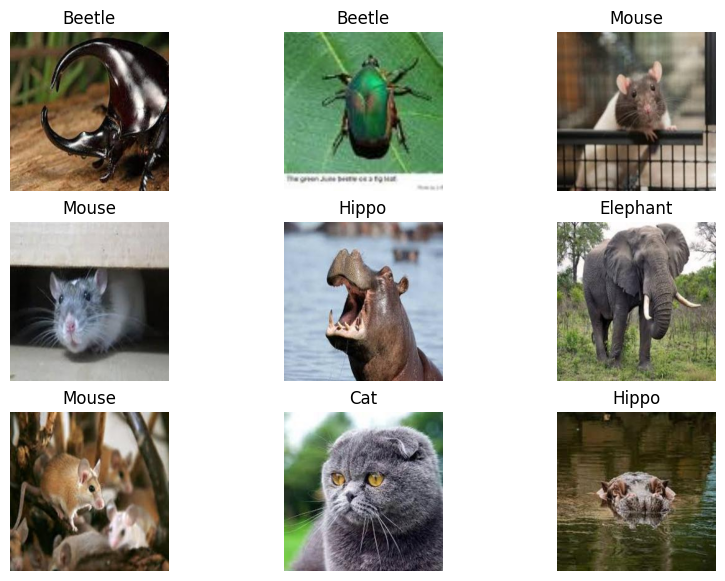

In [13]:
plt.figure(figsize=(10,7))
for i, row in test_df.sample(n=9).reset_index().iterrows():
    plt.subplot(3,3,i+1)
    image_path = row['imgpath']
    image = Image.open(image_path)
    plt.imshow(image)
    plt.title(row["labels"])
    plt.axis('off')
plt.show()

In [14]:
h=100
w=100
classes = len(df['labels'].unique())
BATCH_SIZE = 16
IMAGE_SIZE = (h, w)

generator = ImageDataGenerator(
    preprocessing_function = tf.keras.applications.efficientnet.preprocess_input
)

# Split the data into 2 categories.
train_images = generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='imgpath',
    y_col='labels',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
)

test_images = generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='imgpath',
    y_col='labels',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 14000 validated image filenames belonging to 10 classes.


Found 6000 validated image filenames belonging to 10 classes.


In [15]:
def residual_block(x, filters, kernel_size=3, stride=1, use_bottleneck=False):
    shortcut = x
    
    if use_bottleneck:
        shortcut = layers.Conv2D(filters, 1, strides=stride, padding='same')(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)

    x = layers.Conv2D(filters, kernel_size, strides=stride, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters, kernel_size, padding='same')(x)
    x = layers.BatchNormalization()(x)

    x = layers.add([x, shortcut])
    x = layers.Activation('relu')(x)
    return x

def ResNet(hp):
    input_shape = (h, w, 3)  # Adjust input shape according to your needs
    num_classes = classes
    input_tensor = layers.Input(shape=input_shape)
    hp_kernel_size = hp.Choice('kernel_size',[5,6,7])
    hp_dropout = hp.Choice('dropout',[0.0,0.2,0.3,0.4])
    
    
    x = layers.Conv2D(64, kernel_size=hp_kernel_size, strides=2, padding='same', data_format='channels_last')(input_tensor)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(hp_dropout)(x)
    x = layers.MaxPooling2D(3, strides=2, padding='same')(x)

    # Residual blocks
    num_blocks_list = [3, 4, 3]
    filters_list = [64, 128, 256]
    for i in range(len(num_blocks_list)):
        num_blocks = num_blocks_list[i]
        filters = filters_list[i]
        stride = 1 if i == 0 else 2

        for j in range(num_blocks):
            x = residual_block(x, filters, stride=stride if j == 0 else 1, use_bottleneck=(j == 0 and i > 0))

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs=input_tensor, outputs=x, name='resnet')
    model.compile(optimizer=tf.optimizers.Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [16]:
tuner= kt.GridSearch(ResNet,
                     objective='val_accuracy',
                     project_name='ResNet_tuning')

In [17]:
classes = len(df['labels'].unique())
BATCH_SIZE = 64
IMAGE_SIZE = (h, w)

generator = ImageDataGenerator(
    preprocessing_function = tf.keras.applications.efficientnet.preprocess_input
)

# Split the data into 2 categories.
train_data_generator = generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='imgpath',
    y_col='labels',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
)

val_data_generator = generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='imgpath',
    y_col='labels',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)



Found 14000 validated image filenames belonging to 10 classes.
Found 6000 validated image filenames belonging to 10 classes.


In [18]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=8)
tuner.search(train_data_generator,validation_data=val_data_generator, epochs=1000,validation_split=0.2 , callbacks=[es])

Trial 12 Complete [00h 02m 06s]
val_accuracy: 0.5533333420753479

Best val_accuracy So Far: 0.6790000200271606
Total elapsed time: 00h 31m 05s


In [20]:
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
print(best_hps.values)

{'kernel_size': 7, 'dropout': 0.2}


In [12]:
batch_sizes = [32,64,128]
losses = []
accuracies = []
for b in batch_sizes:
    classes = len(df['labels'].unique())
    BATCH_SIZE = b
    IMAGE_SIZE = (h, w)

    generator = ImageDataGenerator(
        preprocessing_function = tf.keras.applications.efficientnet.preprocess_input
    )

    # Split the data into 2 categories.
    train_data_generator = generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='imgpath',
        y_col='labels',
        target_size=IMAGE_SIZE,
        color_mode='rgb',
        class_mode='categorical',
        batch_size=BATCH_SIZE,
        shuffle=True,
        seed=42,
    )

    val_data_generator = generator.flow_from_dataframe(
        dataframe=test_df,
        x_col='imgpath',
        y_col='labels',
        target_size=IMAGE_SIZE,
        color_mode='rgb',
        class_mode='categorical',
        batch_size=BATCH_SIZE,
        shuffle=False
    )


    # Initialize and compile the model
    resnet_model = tuner.hypermodel.build(best_hps)  # Adjust num_classes as needed


    # Train the model
    es = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=5)
    mc = tf.keras.callbacks.ModelCheckpoint(f'resnet_fold_{batch_sizes}.h5', monitor='val_accuracy', mode='max', save_best_only=True)

    history = resnet_model.fit(
        train_data_generator,
        validation_data=val_data_generator,
        epochs=200,  # Adjust as needed
        callbacks=[es, mc],
        verbose=1,
    )

    # Evaluate on the validation set
    val_loss, val_acc = resnet_model.evaluate(val_data_generator, verbose=1)
    losses.append(val_loss)
    accuracies.append(val_acc)
    print(f'Validation Accuracy: {val_acc * 100:.2f}%')

Found 9800 validated image filenames belonging to 7 classes.
Found 4200 validated image filenames belonging to 7 classes.
Epoch 1/200
307/307 [==============================] - ETA: 0s - loss: 1.5463 - accuracy: 0.4227

/home/j/miniconda3/envs/gen/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


307/307 [==============================] - 18s 34ms/step - loss: 1.5463 - accuracy: 0.4227 - val_loss: 1.9869 - val_accuracy: 0.3381
Epoch 2/200
307/307 [==============================] - 9s 31ms/step - loss: 1.1609 - accuracy: 0.5831 - val_loss: 1.4869 - val_accuracy: 0.5093
Epoch 3/200
307/307 [==============================] - 9s 29ms/step - loss: 0.8855 - accuracy: 0.6887 - val_loss: 1.6971 - val_accuracy: 0.4800
Epoch 4/200
307/307 [==============================] - 9s 29ms/step - loss: 0.6299 - accuracy: 0.7792 - val_loss: 2.1304 - val_accuracy: 0.4402
Epoch 5/200
307/307 [==============================] - 9s 29ms/step - loss: 0.4499 - accuracy: 0.8435 - val_loss: 1.5903 - val_accuracy: 0.5717
Epoch 6/200
307/307 [==============================] - 9s 28ms/step - loss: 0.3023 - accuracy: 0.8953 - val_loss: 2.0652 - val_accuracy: 0.4940
Epoch 7/200
307/307 [==============================] - 9s 30ms/step - loss: 0.2301 - accuracy: 0.9205 - val_loss: 1.7132 - val_accuracy: 0.5743
Epo

/home/j/miniconda3/envs/gen/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


154/154 [==============================] - 17s 53ms/step - loss: 1.5732 - accuracy: 0.4241 - val_loss: 1.6372 - val_accuracy: 0.3467
Epoch 2/200
154/154 [==============================] - 7s 45ms/step - loss: 1.0939 - accuracy: 0.6061 - val_loss: 2.1794 - val_accuracy: 0.3379
Epoch 3/200
154/154 [==============================] - 7s 48ms/step - loss: 0.7944 - accuracy: 0.7168 - val_loss: 1.3389 - val_accuracy: 0.5440
Epoch 4/200
154/154 [==============================] - 7s 46ms/step - loss: 0.5171 - accuracy: 0.8199 - val_loss: 2.1695 - val_accuracy: 0.4333
Epoch 5/200
154/154 [==============================] - 7s 46ms/step - loss: 0.3225 - accuracy: 0.8881 - val_loss: 2.0757 - val_accuracy: 0.4824
Epoch 6/200
154/154 [==============================] - 7s 48ms/step - loss: 0.2763 - accuracy: 0.9038 - val_loss: 1.7699 - val_accuracy: 0.5583
Epoch 7/200
154/154 [==============================] - 7s 46ms/step - loss: 0.2121 - accuracy: 0.9267 - val_loss: 2.0499 - val_accuracy: 0.5619
Epo

/home/j/miniconda3/envs/gen/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


77/77 [==============================] - 16s 106ms/step - loss: 1.6363 - accuracy: 0.3923 - val_loss: 2.0525 - val_accuracy: 0.2007
Epoch 2/200
77/77 [==============================] - 7s 85ms/step - loss: 1.0637 - accuracy: 0.6287 - val_loss: 2.0367 - val_accuracy: 0.2488
Epoch 3/200
77/77 [==============================] - 7s 86ms/step - loss: 0.6437 - accuracy: 0.7805 - val_loss: 2.2610 - val_accuracy: 0.3479
Epoch 4/200
77/77 [==============================] - 7s 85ms/step - loss: 0.3672 - accuracy: 0.8755 - val_loss: 1.8598 - val_accuracy: 0.4700
Epoch 5/200
77/77 [==============================] - 6s 83ms/step - loss: 0.2172 - accuracy: 0.9253 - val_loss: 3.7456 - val_accuracy: 0.3357
Epoch 6/200
77/77 [==============================] - 6s 84ms/step - loss: 0.1709 - accuracy: 0.9403 - val_loss: 3.6314 - val_accuracy: 0.3936
Epoch 7/200
77/77 [==============================] - 7s 85ms/step - loss: 0.1482 - accuracy: 0.9526 - val_loss: 2.4434 - val_accuracy: 0.4848
Epoch 8/200
77/7

In [13]:
print(losses)
print(accuracies)

[2.444133758544922, 2.1904330253601074, 2.8906309604644775]
[0.5371428728103638, 0.5842857360839844, 0.5035714507102966]


In [ ]:
h=100
w=100
BATCH_SIZE = 64
IMAGE_SIZE = (h, w)

# Stratified K-Fold cross-validation
stratified_kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Variables to store results
all_histories = []
all_auc = []
all_precisions = []
all_recalls = []
all_f1_scores = []
all_mcc = []
all_losses = []
all_fpr = []  
all_tpr = []

# Iterate through the folds
for fold, (train_idx, val_idx) in enumerate(stratified_kfold.split(train_df['imgpath'], train_df['labels'])):
    print(f'Fold {fold + 1}')

    generator = ImageDataGenerator(
    preprocessing_function = tf.keras.applications.efficientnet.preprocess_input)

    # Split data into training and validation sets
    train_fold_df, val_fold_df = train_df.iloc[train_idx], train_df.iloc[val_idx]

    # Reset indices
    train_fold_df = train_fold_df.reset_index(drop=True)
    val_fold_df = val_fold_df.reset_index(drop=True)

    # Data generators
    train_data_generator = generator.flow_from_dataframe(
        dataframe=train_fold_df,
        x_col='imgpath',
        y_col='labels',
        target_size=IMAGE_SIZE,
        color_mode='rgb',
        class_mode='categorical',
        batch_size=BATCH_SIZE,
        shuffle=True,
        seed=42,
    )

    val_data_generator = generator.flow_from_dataframe(
        dataframe=val_fold_df,
        x_col='imgpath',
        y_col='labels',
        target_size=IMAGE_SIZE,
        color_mode='rgb',
        class_mode='categorical',
        batch_size=BATCH_SIZE,
        shuffle=False,
    )

    # Initialize and compile the model
    resnet_model = tuner.hypermodel.build(best_hps)  # Adjust num_classes as needed


    # Train the model
    
    mc = tf.keras.callbacks.ModelCheckpoint(f'resnet_fold_{fold + 1}.h5', monitor='val_accuracy', mode='max', save_best_only=True)

    history = resnet_model.fit(
        train_data_generator,
        validation_data=val_data_generator,
        epochs=200,  # Adjust as needed
        callbacks=[es, mc],
        verbose=1,
    )

    # Evaluate on the validation set
    val_loss, val_acc = resnet_model.evaluate(val_data_generator, verbose=1)
    print(f'Validation Accuracy: {val_acc * 100:.2f}%')

    # Store history
    all_histories.append(history)
    # Plot AUC-ROC
    val_predictions = resnet_model.predict(val_data_generator)
    fpr, tpr, _ = roc_curve(val_data_generator.classes, val_predictions[:, 1])
    roc_auc = auc(fpr, tpr)
    all_auc.append(roc_auc)
    all_fpr.append(fpr)
    all_tpr.append(tpr)

    # Plot Precision-Recall curve
    precision, recall, _ = precision_recall_curve(val_data_generator.classes, val_predictions[:, 1])
    all_precisions.append(precision)
    all_recalls.append(recall)

    # Calculate and store F1 score, MCC, and loss
    true_labels = val_data_generator.classes
    predicted_labels = np.argmax(val_predictions, axis=1)
    f1 = f1_score(true_labels, predicted_labels)
    mcc = matthews_corrcoef(true_labels, predicted_labels)
    all_f1_scores.append(f1)
    all_mcc.append(mcc)
    all_losses.append(val_loss)

# Print average validation accuracy over all folds
avg_val_acc = np.mean([h.history['val_accuracy'][-1] for h in all_histories])
print(f'Average Validation Accuracy: {avg_val_acc * 100:.2f}%')
# Plot AUC-ROC curve
mean_fpr = np.linspace(0, 1, 100)
mean_tpr = np.mean([np.interp(mean_fpr, fpr, tpr) for fpr, tpr in zip(all_fpr, all_tpr)], axis=0)
plt.figure()
plt.plot(mean_fpr, mean_tpr, color='b', label='Mean ROC (AUC = {:.2f})'.format(np.mean(all_auc)))
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Mean ROC Curve')
plt.legend(loc='lower right')
plt.show()

# Plot Precision-Recall curve
mean_precision = np.mean(all_precisions, axis=0)
mean_recall = np.mean(all_recalls, axis=0)
plt.figure()
plt.plot(mean_recall, mean_precision, color='b', label='Mean Precision-Recall')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Mean Precision-Recall Curve')
plt.legend(loc='upper right')
plt.show()

# Plot Mean Loss vs. Epochs
mean_train_loss = np.mean([h.history['loss'] for h in all_histories], axis=0)
mean_val_loss = np.mean([h.history['val_loss'] for h in all_histories], axis=0)
epochs = range(1, len(mean_train_loss) + 1)
plt.figure()
plt.plot(epochs, mean_train_loss, 'bo', label='Mean Training Loss')
plt.plot(epochs, mean_val_loss, 'r', label='Mean Validation Loss')
plt.title('Mean Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Print average metrics over all folds
avg_f1 = np.mean(all_f1_scores)
avg_mcc = np.mean(all_mcc)
avg_loss = np.mean(all_losses)
print(f'Average F1 Score: {avg_f1:.4f}')
print(f'Average Matthews Correlation Coefficient (MCC): {avg_mcc:.4f}')
print(f'Average Validation Loss: {avg_loss:.4f}')

## Model 2

In [ ]:
path="animals/animals"
data = {"imgpath": [] , "labels": [] }

category = os.listdir(path)
for folder in category:
    folderpath = os.path.join(path , folder)
    filelist = os.listdir(folderpath)
    for file in filelist:
        fpath = os.path.join(folderpath, file)
        data["imgpath"].append(fpath)
        data["labels"].append(folder)
      
print(data["labels"])
df = pd.DataFrame(data) 

#Convert labels to numbers
lb = LabelEncoder()
df['encoded_labels'] = lb.fit_transform(df['labels'])

In [ ]:
train_df, test_df = train_test_split(df, test_size=0.3, shuffle=True, random_state=124)
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

print("----------Train-------------")
print(train_df[["imgpath", "labels"]].head(5))
print(train_df.shape)
print("----------Test--------------")
print(test_df[["imgpath", "labels"]].head(5))
print(test_df.shape)

In [ ]:
h=100
w=100
classes = len(df['labels'].unique())
BATCH_SIZE = 16
IMAGE_SIZE = (h, w)

generator = ImageDataGenerator(
    preprocessing_function = tf.keras.applications.efficientnet.preprocess_input
)

# Split the data into 2 categories.
train_images = generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='imgpath',
    y_col='labels',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
)

test_images = generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='imgpath',
    y_col='labels',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

In [ ]:
def residual_block(x, filters, kernel_size=3, stride=1, use_bottleneck=False):
    shortcut = x
    
    if use_bottleneck:
        shortcut = layers.Conv2D(filters, 1, strides=stride, padding='same')(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)

    x = layers.Conv2D(filters, kernel_size, strides=stride, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters, kernel_size, padding='same')(x)
    x = layers.BatchNormalization()(x)

    x = layers.add([x, shortcut])
    x = layers.Activation('relu')(x)
    return x

def ResNet(hp):
    input_shape = (h, w, 3)  # Adjust input shape according to your needs
    num_classes = classes
    input_tensor = layers.Input(shape=input_shape)
    hp_kernel_size = hp.Choice('kernel_size',[5,6,7])
    hp_dropout = hp.Choice('dropout',[0.0,0.2,0.3,0.4])
    
    
    x = layers.Conv2D(64, kernel_size=hp_kernel_size, strides=2, padding='same', data_format='channels_last')(input_tensor)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(hp_dropout)(x)
    x = layers.MaxPooling2D(3, strides=2, padding='same')(x)

    # Residual blocks
    num_blocks_list = [3, 4, 6, 3] 
    filters_list = [64, 128, 256, 512]
    for i in range(len(num_blocks_list)):
        num_blocks = num_blocks_list[i]
        filters = filters_list[i]
        stride = 1 if i == 0 else 2

        for j in range(num_blocks):
            x = residual_block(x, filters, stride=stride if j == 0 else 1, use_bottleneck=(j == 0 and i > 0))

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs=input_tensor, outputs=x, name='resnet')
    model.compile(optimizer=tf.optimizers.Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=8)
tuner.search(train_data_generator,validation_data=val_data_generator, epochs=1000,validation_split=0.2 , callbacks=[es])

In [ ]:
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
print(best_hps.values)

In [ ]:
batch_sizes = [32,64,128]
losses = []
accuracies = []
for b in batch_sizes:
    classes = len(df['labels'].unique())
    BATCH_SIZE = b
    IMAGE_SIZE = (h, w)

    generator = ImageDataGenerator(
        preprocessing_function = tf.keras.applications.efficientnet.preprocess_input
    )

    # Split the data into 2 categories.
    train_data_generator = generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='imgpath',
        y_col='labels',
        target_size=IMAGE_SIZE,
        color_mode='rgb',
        class_mode='categorical',
        batch_size=BATCH_SIZE,
        shuffle=True,
        seed=42,
    )

    val_data_generator = generator.flow_from_dataframe(
        dataframe=test_df,
        x_col='imgpath',
        y_col='labels',
        target_size=IMAGE_SIZE,
        color_mode='rgb',
        class_mode='categorical',
        batch_size=BATCH_SIZE,
        shuffle=False
    )


    # Initialize and compile the model
    resnet_model = tuner.hypermodel.build(best_hps)  # Adjust num_classes as needed


    # Train the model
    es = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=5)
    mc = tf.keras.callbacks.ModelCheckpoint(f'resnet_fold_{batch_sizes}.h5', monitor='val_accuracy', mode='max', save_best_only=True)

    history = resnet_model.fit(
        train_data_generator,
        validation_data=val_data_generator,
        epochs=200,  # Adjust as needed
        callbacks=[es, mc],
        verbose=1,
    )

    # Evaluate on the validation set
    val_loss, val_acc = resnet_model.evaluate(val_data_generator, verbose=1)
    losses.append(val_loss)
    accuracies.append(val_acc)
    print(f'Validation Accuracy: {val_acc * 100:.2f}%')

In [ ]:
print(losses)
print(accuracies)

### Modificar esto en base a lo que salga arriba

In [ ]:
h=100
w=100
BATCH_SIZE = 64
IMAGE_SIZE = (h, w)

# Stratified K-Fold cross-validation
stratified_kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Variables to store results
all_histories = []
all_auc = []
all_precisions = []
all_recalls = []
all_f1_scores = []
all_mcc = []
all_losses = []
all_fpr = []  
all_tpr = []

# Iterate through the folds
for fold, (train_idx, val_idx) in enumerate(stratified_kfold.split(train_df['imgpath'], train_df['labels'])):
    print(f'Fold {fold + 1}')

    generator = ImageDataGenerator(
    preprocessing_function = tf.keras.applications.efficientnet.preprocess_input)

    # Split data into training and validation sets
    train_fold_df, val_fold_df = train_df.iloc[train_idx], train_df.iloc[val_idx]

    # Reset indices
    train_fold_df = train_fold_df.reset_index(drop=True)
    val_fold_df = val_fold_df.reset_index(drop=True)

    # Data generators
    train_data_generator = generator.flow_from_dataframe(
        dataframe=train_fold_df,
        x_col='imgpath',
        y_col='labels',
        target_size=IMAGE_SIZE,
        color_mode='rgb',
        class_mode='categorical',
        batch_size=BATCH_SIZE,
        shuffle=True,
        seed=42,
    )

    val_data_generator = generator.flow_from_dataframe(
        dataframe=val_fold_df,
        x_col='imgpath',
        y_col='labels',
        target_size=IMAGE_SIZE,
        color_mode='rgb',
        class_mode='categorical',
        batch_size=BATCH_SIZE,
        shuffle=False,
    )

    # Initialize and compile the model
    resnet_model = tuner.hypermodel.build(best_hps)  # Adjust num_classes as needed


    # Train the model
    
    mc = tf.keras.callbacks.ModelCheckpoint(f'resnet_fold_{fold + 1}.h5', monitor='val_accuracy', mode='max', save_best_only=True)

    history = resnet_model.fit(
        train_data_generator,
        validation_data=val_data_generator,
        epochs=200,  # Adjust as needed
        callbacks=[es, mc],
        verbose=1,
    )

    # Evaluate on the validation set
    val_loss, val_acc = resnet_model.evaluate(val_data_generator, verbose=1)
    print(f'Validation Accuracy: {val_acc * 100:.2f}%')

    # Store history
    all_histories.append(history)
    # Plot AUC-ROC
    val_predictions = resnet_model.predict(val_data_generator)
    fpr, tpr, _ = roc_curve(val_data_generator.classes, val_predictions[:, 1])
    roc_auc = auc(fpr, tpr)
    all_auc.append(roc_auc)
    all_fpr.append(fpr)
    all_tpr.append(tpr)

    # Plot Precision-Recall curve
    precision, recall, _ = precision_recall_curve(val_data_generator.classes, val_predictions[:, 1])
    all_precisions.append(precision)
    all_recalls.append(recall)

    # Calculate and store F1 score, MCC, and loss
    true_labels = val_data_generator.classes
    predicted_labels = np.argmax(val_predictions, axis=1)
    f1 = f1_score(true_labels, predicted_labels)
    mcc = matthews_corrcoef(true_labels, predicted_labels)
    all_f1_scores.append(f1)
    all_mcc.append(mcc)
    all_losses.append(val_loss)

# Print average validation accuracy over all folds
avg_val_acc = np.mean([h.history['val_accuracy'][-1] for h in all_histories])
print(f'Average Validation Accuracy: {avg_val_acc * 100:.2f}%')
# Plot AUC-ROC curve
mean_fpr = np.linspace(0, 1, 100)
mean_tpr = np.mean([np.interp(mean_fpr, fpr, tpr) for fpr, tpr in zip(all_fpr, all_tpr)], axis=0)
plt.figure()
plt.plot(mean_fpr, mean_tpr, color='b', label='Mean ROC (AUC = {:.2f})'.format(np.mean(all_auc)))
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Mean ROC Curve')
plt.legend(loc='lower right')
plt.show()

# Plot Precision-Recall curve
mean_precision = np.mean(all_precisions, axis=0)
mean_recall = np.mean(all_recalls, axis=0)
plt.figure()
plt.plot(mean_recall, mean_precision, color='b', label='Mean Precision-Recall')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Mean Precision-Recall Curve')
plt.legend(loc='upper right')
plt.show()

# Plot Mean Loss vs. Epochs
mean_train_loss = np.mean([h.history['loss'] for h in all_histories], axis=0)
mean_val_loss = np.mean([h.history['val_loss'] for h in all_histories], axis=0)
epochs = range(1, len(mean_train_loss) + 1)
plt.figure()
plt.plot(epochs, mean_train_loss, 'bo', label='Mean Training Loss')
plt.plot(epochs, mean_val_loss, 'r', label='Mean Validation Loss')
plt.title('Mean Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Print average metrics over all folds
avg_f1 = np.mean(all_f1_scores)
avg_mcc = np.mean(all_mcc)
avg_loss = np.mean(all_losses)
print(f'Average F1 Score: {avg_f1:.4f}')
print(f'Average Matthews Correlation Coefficient (MCC): {avg_mcc:.4f}')
print(f'Average Validation Loss: {avg_loss:.4f}')